## Lab 2
### Part 2: Dealing with overfitting

Today we work with [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist) (*hint: it is available in `torchvision`*).

Your goal for today:
1. Train a FC (fully-connected) network that achieves >= 0.885 test accuracy.
2. Cause considerable overfitting by modifying the network (e.g. increasing the number of network parameters and/or layers) and demonstrate in in the appropriate way (e.g. plot loss and accurasy on train and validation set w.r.t. network complexity).
3. Try to deal with overfitting (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results.

__Please, write a small report describing your ideas, tries and achieved results in the end of this file.__

*Note*: Tasks 2 and 3 are interrelated, in task 3 your goal is to make the network from task 2 less prone to overfitting. Task 1 is independent from 2 and 3.

*Note 2*: We recomment to use Google Colab or other machine with GPU acceleration.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torchsummary
from IPython.display import clear_output
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import os


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [2]:
# Technical function
def mkdir(path):
    if not os.path.exists(root_path):
        os.mkdir(root_path)
        print('Directory', path, 'is created!')
    else:
        print('Directory', path, 'already exists!')
        
root_path = 'fmnist'
mkdir(root_path)

Directory fmnist already exists!


In [3]:
download = True
train_transform = transforms.ToTensor()
test_transform = transforms.ToTensor()
transforms.Compose((transforms.ToTensor()))


fmnist_dataset_train = torchvision.datasets.FashionMNIST(root_path, 
                                                        train=True, 
                                                        transform=train_transform,
                                                        target_transform=None,
                                                        download=download)

fmnist_dataset_test = torchvision.datasets.FashionMNIST(root_path, 
                                                       train=False, 
                                                       transform=test_transform,
                                                       target_transform=None,
                                                       download=download)

In [4]:
train_loader = torch.utils.data.DataLoader(fmnist_dataset_train, 
                                           batch_size=128,
                                           shuffle=True,
                                           num_workers=2)

test_loader = torch.utils.data.DataLoader(fmnist_dataset_test,
                                          batch_size=256,
                                          shuffle=False,
                                          num_workers=2)

In [5]:
len(fmnist_dataset_test)

10000

In [6]:
for img, label in train_loader:
    print(img.shape)
    print(label.shape)
    print(label.size(0))
    break

torch.Size([128, 1, 28, 28])
torch.Size([128])
128


### Task 1
Train a network that achieves $\geq 0.885$ test accuracy. It's fine to use only Linear (`nn.Linear`) layers and activations/dropout/batchnorm. Convolutional layers might be a great use, but we will meet them a bit later.

In [7]:
class TinyNeuralNetwork(nn.Module):

    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):    
        out = self.model(inp)
        return out

In [8]:
torchsummary.summary(TinyNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 256]         200,960
              ReLU-3                  [-1, 256]               0
            Linear-4                  [-1, 128]          32,896
              ReLU-5                  [-1, 128]               0
            Linear-6                   [-1, 10]           1,290
Total params: 235,146
Trainable params: 235,146
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.90
Estimated Total Size (MB): 0.91
----------------------------------------------------------------


Your experiments come here:

In [9]:
model = TinyNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, training and validation loops here
def train_(train_data: object,
           model: object,
           loss: object,
           optimizer: object,
           device: str = 'cuda:0') -> float:

    size = len(train_data.dataset)
    batch_size = len(train_data)

    model.train()
    losses = 0

    for batch, (X_train, y_train) in enumerate(train_data):
        pred = model(X_train.to(device))
        loss_calculated = loss(pred, y_train.to(device))

        loss_calculated.backward()
        optimizer.step()
        optimizer.zero_grad()
        losses += loss_calculated.item()

        if batch % 100 == 0:
            loss_calculated, current = loss_calculated.item(), (batch + 1) * len(X_train)
            print(f'Loss: {loss_calculated:>7f}  [{current:>5d}/{size:>5d}]')

    return losses / batch_size


def test_(test_data: object,
          model: object,
          loss: object,
          device: str = 'cuda:0') -> float:

    model.eval()
    size = len(test_data.dataset)
    batch_num = len(test_data)
    losses = 0
    accuracy = 0

    with torch.no_grad():
        for X_test, y_test in test_data:
            pred = model(X_test.to(device))
            losses += loss(pred, y_test.to(device)).item()
            accuracy += (pred.argmax(1) == y_test.to(device)).type(torch.float).sum().item()
            batch_num += 1

    losses = losses / batch_num
    accuracy = accuracy / size
    print(f'Accuracy: {(100 * accuracy):>0.1f}%,\nAvg loss: {losses:>8f} \n')
    return accuracy


def hl_plot(history: dict):
    plt.figure(figsize=(10, 6))

    plt.plot(history['losses'],
            marker='o',
            linestyle='--',
            color='blue',
            label='Train losses')

    plt.plot(history['accuracy'],
            marker='o',
            linestyle='--',
            color='red',
            label='Test accuracy')

    plt.xlabel('Epoch.')
    plt.ylabel('%')
    plt.legend()
    plt.title('Accuracy/losses pivot graph.')
    plt.show()


In [10]:
history = {
      "losses": [],
      "accuracy": []
}

i = 1
epochs = 40

while i <= epochs:
      clear_output(wait=True)
      print(f'\n---\nEpoch: {i}/{epochs}')
      history['losses'].append(train_(train_loader, model, loss_func, opt))
      history['accuracy'].append(test_(test_loader, model, loss_func))
      i += 1


---
Epoch: 40/40
Loss: 0.119553  [  128/60000]
Loss: 0.135640  [12928/60000]
Loss: 0.116589  [25728/60000]
Loss: 0.111545  [38528/60000]
Loss: 0.059263  [51328/60000]
Accuracy: 89.3%,
Avg loss: 0.178438 



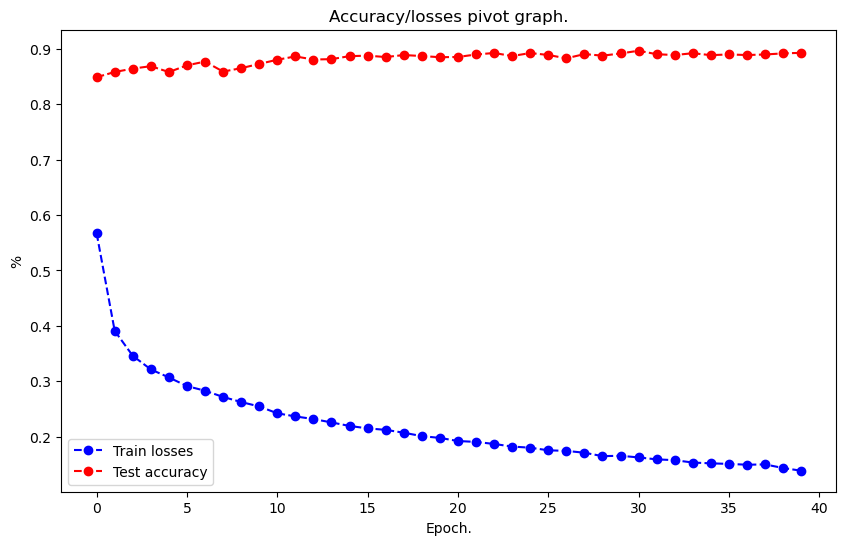

In [11]:
hl_plot(history)

### Task 2: Overfit it.
Build a network that will overfit to this dataset. Demonstrate the overfitting in the appropriate way (e.g. plot loss and accurasy on train and test set w.r.t. network complexity).

*Note:* you also might decrease the size of `train` dataset to enforce the overfitting and speed up the computations.

In [12]:
class OverfittingNeuralNetwork(nn.Module):

    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(), # This layer converts image into a vector to use Linear layers afterwards
            # Your network structure comes here
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):    
        out = self.model(inp)
        return out

In [13]:
torchsummary.summary(OverfittingNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
            Linear-4                  [-1, 512]         524,800
              ReLU-5                  [-1, 512]               0
            Linear-6                  [-1, 256]         131,328
              ReLU-7                  [-1, 256]               0
            Linear-8                  [-1, 128]          32,896
              ReLU-9                  [-1, 128]               0
           Linear-10                   [-1, 10]           1,290
Total params: 1,494,154
Trainable params: 1,494,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 5.70
Estimat

In [14]:
model = OverfittingNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
dataset_size = len(fmnist_dataset_train)
subset_size = int(0.1 * dataset_size)
indices = np.random.permutation(dataset_size)[:subset_size]
fmnist_subset = torch.utils.data.Subset(fmnist_dataset_train, indices)
train_loader = torch.utils.data.DataLoader(fmnist_subset, batch_size=128, shuffle=True, num_workers=2)



i = 1
epochs = 100

history = {
      "losses": [],
      "accuracy": []
}

while i <= epochs:
      clear_output(wait=True)
      print(f'\n---\nEpoch: {i}/{epochs}')
      history['losses'].append(train_(train_loader, model, loss_func, opt))
      history['accuracy'].append(test_(test_loader, model, loss_func))
      i += 1


---
Epoch: 100/100
Loss: 0.152479  [  128/ 6000]
Accuracy: 84.3%,
Avg loss: 0.338250 



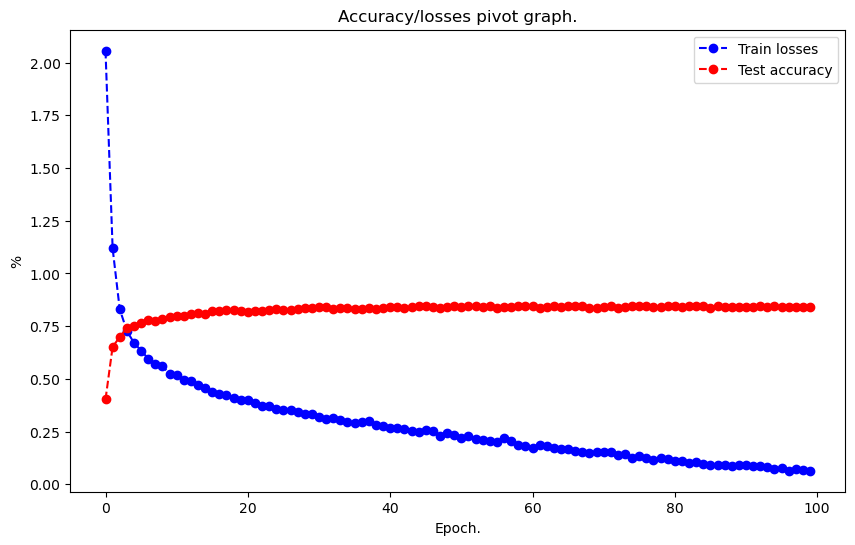

In [15]:
hl_plot(history)

### Task 3: Fix it.
Fix the overfitted network from the previous step (at least partially) by using regularization techniques (Dropout/Batchnorm/...) and demonstrate the results. 

In [16]:
class FixedNeuralNetwork(nn.Module):

    def __init__(self, input_shape=28*28, num_classes=10, input_channels=1):
        super(self.__class__, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_shape, 1024),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )

    def forward(self, inp):    
        out = self.model(inp)
        return out

In [17]:
torchsummary.summary(FixedNeuralNetwork().to(device), (28*28,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                 [-1, 1024]         803,840
              ReLU-3                 [-1, 1024]               0
           Dropout-4                 [-1, 1024]               0
            Linear-5                  [-1, 512]         524,800
              ReLU-6                  [-1, 512]               0
           Dropout-7                  [-1, 512]               0
            Linear-8                  [-1, 256]         131,328
              ReLU-9                  [-1, 256]               0
          Dropout-10                  [-1, 256]               0
           Linear-11                  [-1, 128]          32,896
             ReLU-12                  [-1, 128]               0
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [18]:
model = FixedNeuralNetwork().to(device)
opt = torch.optim.Adam(model.parameters(), lr=0.003, weight_decay=1e-4)
loss_func = nn.CrossEntropyLoss()

# Your experiments, come here
i = 1
epochs = 50

history = {
      "losses": [],
      "accuracy": []
}

while i <= epochs:
      clear_output(wait=True)
      print(f'\n---\nEpoch: {i}/{epochs}')
      history['losses'].append(train_(train_loader, model, loss_func, opt))
      history['accuracy'].append(test_(test_loader, model, loss_func))
      i += 1


---
Epoch: 50/50
Loss: 0.500629  [  128/ 6000]
Accuracy: 84.0%,
Avg loss: 0.237154 



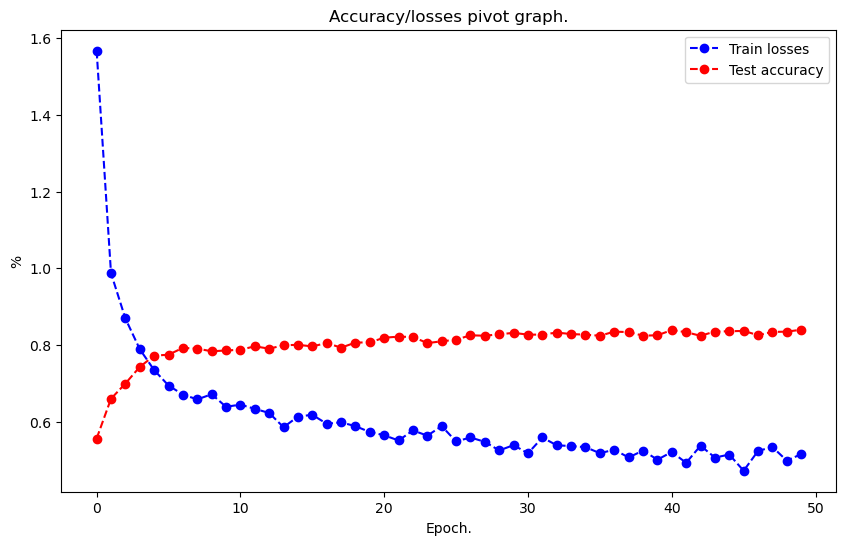

In [19]:
hl_plot(history)

### Conclusions:


#### Task 1:

1. Представленная модель на линейных слоях показывает точность 88.2 - 88.7%
2. Функция оптимизации - Adam, с параметром `lr = 0.001`, а `weight_decay = 1e-4`.
3. Функция потерь - CrossEntropyLoss.

Выводы по графику:

1. Потери снижаются, что обозначает эффективное обучение модели.
2. Стабильно высокая точность. Количество эпох можно снизить, так как максимальная эффективность достигается на 10-15 эпохе.
3. Отсутствует явный разрыв между потерями и точностью, что обозначает фиксирование решений насчет данных, а не просто запоминает их.

#### Task 2:

Эффект переобучения был достигнут за счет большого количества линейных слоев с большим количеством нейронов, а также малым L2 и большим количеством итераций на урезанном наборе данных. 

1. Потери стремятся к нулю при большом числе эпох.
2. Точность достигает плато и не повышается.
3. Большая разница между тренировочными потерями и тестовой точностью.

#### Task 3:

При проведении эксперимента с устранением переобучения были сохранены следующие условия:

- Структура модели изменилась незначительно, в нее были добавлены только Dropout слои.
- Тесты проведены на том же урезанном наборе данных.
- Значения итерации и параметры оптимизатора приведены к оптимальным.

Как изменился график:

1. Тестовая точность достигла большей стабильности, а её значение увеличилось.
2. Потери стали снижаться медленнее, что свидетельствует о работе Dropout и уменьшении избыточного запоминания.
3. Разрыв уменьшился.

#### Summary:

За счет внедрения Dropout слоя было незначительно увеличено общее качество модели, склонной к переобучению.